In [40]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import evaluate

In [41]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU доступен: {torch.cuda.get_device_name(0)}")

GPU доступен: NVIDIA GeForce RTX 4060 Ti


In [42]:
# 1. Загрузка и предобработка данных
def load_and_preprocess_data():
    df = pd.read_csv('../data/phoebe_quotes.csv')
    df['quote'] = df['quote'].apply(lambda x: x.strip())
    df['quote'] = "<START> " + df['quote'] + " <END>"
    train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)
    return train_dataset, test_dataset

In [62]:
# 2. Токенизация данных
def tokenize_data(train_dataset, test_dataset):
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    def tokenize_function(examples):
        # Токенизация текста
        tokenized = tokenizer(
            examples['quote'],
            padding="max_length",
            truncation=True,
            max_length=50,
            return_tensors="pt",
        )
        # Добавляем метки (labels) — те же input_ids, но сдвинутые на один токен
        tokenized["labels"] = tokenized["input_ids"].clone()
        return tokenized
    
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)
    return train_dataset, test_dataset, tokenizer

In [63]:
# Загружаем и предобрабатываем данные
train_dataset, test_dataset = load_and_preprocess_data()

# Токенизируем данные
train_dataset, test_dataset, tokenizer = tokenize_data(train_dataset, test_dataset)

Map:   0%|          | 0/6421 [00:00<?, ? examples/s]

Map:   0%|          | 0/714 [00:00<?, ? examples/s]

In [46]:
# Визуализация Perplexity
def plot_perplexity(train_losses, val_losses):
    train_perplexities = [np.exp(loss) for loss in train_losses]
    val_perplexities = [np.exp(loss) for loss in val_losses]
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_perplexities, label="Training Perplexity")
    plt.plot(val_perplexities, label="Validation Perplexity")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.title("Training and Validation Perplexity")
    plt.legend()
    plt.grid()
    plt.savefig("./model/training_perplexity.png")
    plt.show()

In [47]:
import evaluate
import nltk
from nltk.tokenize import word_tokenize

# Загрузка данных для nltk (если не загружены)
nltk.download('punkt')

def evaluate_bleu_rouge(test_dataset, model, tokenizer, max_length=50):
    # Загружаем метрики
    bleu = evaluate.load("bleu")
    rouge = evaluate.load("rouge")
    
    bleu_scores = []
    rouge_scores = []
    
    for example in test_dataset:
        input_text = example['quote']
        reference = input_text  # Эталонный текст
        
        # Генерация ответа
        input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
        output = model.generate(input_ids, max_length=max_length, temperature=0.7, top_k=50)
        response = tokenizer.decode(output[0], skip_special_tokens=True)
        
        # Токенизация с помощью nltk
        response_tokens = word_tokenize(response)
        reference_tokens = [word_tokenize(reference)]  # Ожидается список списков
        
        # Вычисляем BLEU
        bleu_score = bleu.compute(predictions=[response_tokens], references=[reference_tokens])
        bleu_scores.append(bleu_score["bleu"])
        
        # Вычисляем ROUGE
        rouge_score = rouge.compute(predictions=[response], references=[reference])
        rouge_scores.append(rouge_score["rougeL"].mid.fmeasure)
    
    return bleu_scores, rouge_scores

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vyacheslav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
import matplotlib.pyplot as plt

def plot_bleu_rouge(bleu_scores, rouge_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(bleu_scores, label="BLEU Score")
    plt.plot(rouge_scores, label="ROUGE Score")
    plt.xlabel("Sample")
    plt.ylabel("Score")
    plt.title("BLEU and ROUGE Scores")
    plt.legend()
    plt.grid()
    plt.savefig("./model/bleu_rouge_scores.png")  # Сохраняем график
    plt.show()

In [64]:
from IPython.display import clear_output
import time

def train_model(train_dataset, test_dataset, tokenizer, training_args):
    model = GPT2LMHeadModel.from_pretrained("gpt2")
    model.config.dropout = 0.5
    model.resize_token_embeddings(len(tokenizer))
    model.to(device)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
    )
    
    train_losses = []
    val_losses = []
    
    for epoch in range(training_args.num_train_epochs):
        
        
        start_time = time.time()
        
        # Обучение
        train_results = trainer.train()
        train_losses.append(train_results.training_loss)
        
        # Валидация
        eval_results = trainer.evaluate()
        val_losses.append(eval_results["eval_loss"])
        
        # Время выполнения эпохи
        epoch_time = time.time() - start_time
        clear_output(wait=True)  # Очищаем вывод перед выводом новой эпохи
        # Вывод информации о текущей эпохе
        print(f"Эпоха {epoch + 1}/{training_args.num_train_epochs}")
        print(f"Training Loss: {train_results.training_loss:.4f}")
        print(f"Validation Loss: {eval_results['eval_loss']:.4f}")
        print(f"Время выполнения эпохи: {epoch_time:.2f} сек")
    
    # Визуализация Perplexity
    plot_perplexity(train_losses, val_losses)
    
    # Сохраняем модель и токенизатор
    model.save_pretrained("./model/gpt2-phoebe")
    tokenizer.save_pretrained("./model/gpt2-phoebe")
    
    return model, tokenizer

  0%|          | 0/2409 [00:00<?, ?it/s]

{'loss': 0.8346, 'grad_norm': 1.6958869695663452, 'learning_rate': 1e-05, 'epoch': 0.12}
{'loss': 0.783, 'grad_norm': 2.275127410888672, 'learning_rate': 2e-05, 'epoch': 0.25}
{'loss': 0.7598, 'grad_norm': 1.873063564300537, 'learning_rate': 3e-05, 'epoch': 0.37}
{'loss': 0.7241, 'grad_norm': 1.90712571144104, 'learning_rate': 4e-05, 'epoch': 0.5}
{'loss': 0.6788, 'grad_norm': 3.011350154876709, 'learning_rate': 5e-05, 'epoch': 0.62}
{'loss': 0.6588, 'grad_norm': 1.6947354078292847, 'learning_rate': 4.738082765845993e-05, 'epoch': 0.75}
{'loss': 0.6705, 'grad_norm': 2.3364570140838623, 'learning_rate': 4.4761655316919856e-05, 'epoch': 0.87}
{'loss': 0.6616, 'grad_norm': 2.2522194385528564, 'learning_rate': 4.214248297537978e-05, 'epoch': 1.0}


  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.9252650141716003, 'eval_runtime': 1.2648, 'eval_samples_per_second': 564.537, 'eval_steps_per_second': 71.16, 'epoch': 1.0}
{'loss': 0.6602, 'grad_norm': 2.464707851409912, 'learning_rate': 3.952331063383971e-05, 'epoch': 1.12}
{'loss': 0.6786, 'grad_norm': 2.1318271160125732, 'learning_rate': 3.6904138292299634e-05, 'epoch': 1.25}
{'loss': 0.6914, 'grad_norm': 1.9443179368972778, 'learning_rate': 3.4284965950759564e-05, 'epoch': 1.37}
{'loss': 0.6851, 'grad_norm': 2.9220221042633057, 'learning_rate': 3.166579360921949e-05, 'epoch': 1.49}
{'loss': 0.6866, 'grad_norm': 2.2056243419647217, 'learning_rate': 2.9046621267679414e-05, 'epoch': 1.62}
{'loss': 0.689, 'grad_norm': 2.257472276687622, 'learning_rate': 2.642744892613934e-05, 'epoch': 1.74}
{'loss': 0.6708, 'grad_norm': 2.6574900150299072, 'learning_rate': 2.380827658459927e-05, 'epoch': 1.87}
{'loss': 0.6846, 'grad_norm': 2.147416114807129, 'learning_rate': 2.1189104243059192e-05, 'epoch': 1.99}


  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.9169736504554749, 'eval_runtime': 1.224, 'eval_samples_per_second': 583.338, 'eval_steps_per_second': 73.53, 'epoch': 2.0}
{'loss': 0.6253, 'grad_norm': 2.788400888442993, 'learning_rate': 1.8569931901519122e-05, 'epoch': 2.12}
{'loss': 0.6417, 'grad_norm': 2.3846936225891113, 'learning_rate': 1.595075955997905e-05, 'epoch': 2.24}
{'loss': 0.5982, 'grad_norm': 2.30021595954895, 'learning_rate': 1.3331587218438973e-05, 'epoch': 2.37}
{'loss': 0.6209, 'grad_norm': 2.7652652263641357, 'learning_rate': 1.0712414876898901e-05, 'epoch': 2.49}
{'loss': 0.582, 'grad_norm': 2.475615978240967, 'learning_rate': 8.093242535358828e-06, 'epoch': 2.62}
{'loss': 0.6369, 'grad_norm': 2.394103527069092, 'learning_rate': 5.4740701938187535e-06, 'epoch': 2.74}
{'loss': 0.632, 'grad_norm': 3.066149950027466, 'learning_rate': 2.85489785227868e-06, 'epoch': 2.86}
{'loss': 0.6119, 'grad_norm': 1.9031493663787842, 'learning_rate': 2.3572551073860661e-07, 'epoch': 2.99}


  0%|          | 0/90 [00:00<?, ?it/s]

{'eval_loss': 0.9556358456611633, 'eval_runtime': 1.2153, 'eval_samples_per_second': 587.491, 'eval_steps_per_second': 74.053, 'epoch': 3.0}


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


{'train_runtime': 221.7619, 'train_samples_per_second': 86.863, 'train_steps_per_second': 10.863, 'train_loss': 0.6732342388680388, 'epoch': 3.0}


  0%|          | 0/90 [00:00<?, ?it/s]

Эпоха 3/3
Training Loss: 0.6732
Validation Loss: 0.9170
Время выполнения эпохи: 223.20 сек


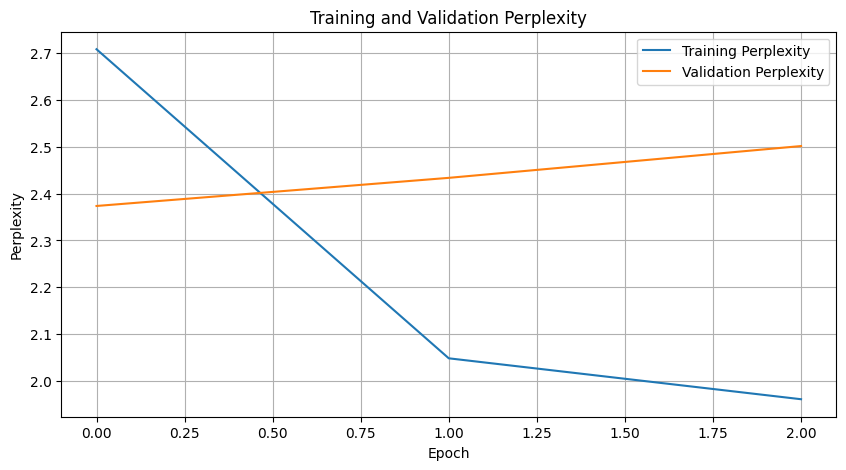

In [38]:
# Настройки обучения
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,  # Увеличиваем батч для GPU
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,  # Используем mixed precision для ускорения обучения
)

# Обучаем модель
model, tokenizer = train_model(train_dataset, test_dataset, tokenizer, training_args)


Попробуем увеличить количество эпох

Эпоха 5/5
Training Loss: 0.4623
Validation Loss: 1.0589
Время выполнения эпохи: 375.04 сек


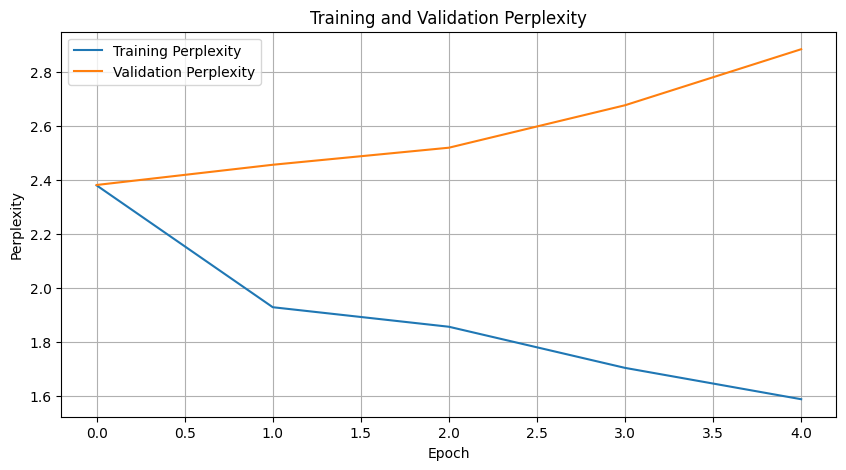

In [51]:
# Настройки обучения
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=8,  # Увеличиваем батч для GPU
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,  # Используем mixed precision для ускорения обучения
)

# Обучаем модель
model, tokenizer = train_model(train_dataset, test_dataset, tokenizer, training_args)


Явно видим переобучение, попробуем следующие шаги:
- Увеличим батч
- Увеличим weight_decay
- Добавим дропаут
- Уменьшим скорость обучения
- Добавим планировщик


Эпоха 5/5
Training Loss: 0.5390
Validation Loss: 0.9799
Время выполнения эпохи: 231.12 сек


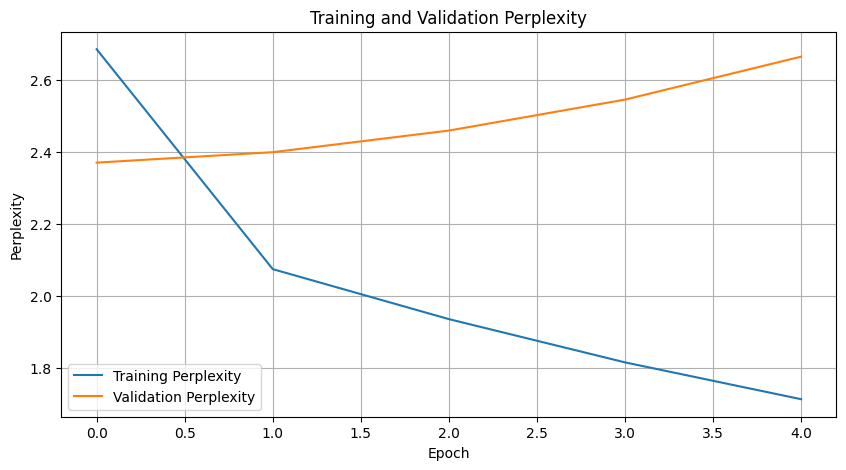

In [55]:
# Настройки обучения
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=16,  # Увеличиваем батч для GPU
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.1,
    logging_dir="./logs",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,  # Используем mixed precision для ускорения обучения
    learning_rate=5e-5,
    lr_scheduler_type="linear",  # Линейное уменьшение скорости обучения
)

# Обучаем модель
model, tokenizer = train_model(train_dataset, test_dataset, tokenizer, training_args)

Эпоха 3/3
Training Loss: 0.6893
Validation Loss: 0.8944
Время выполнения эпохи: 144.05 сек


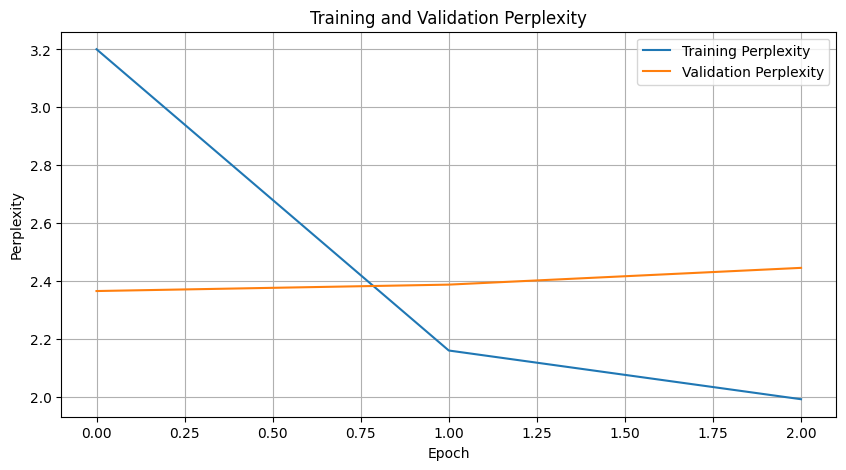

In [57]:
# Настройки обучения
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,  # Увеличиваем батч для GPU
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,  # Используем mixed precision для ускорения обучения
    learning_rate=5e-5,
    lr_scheduler_type="linear",  # Линейное уменьшение скорости обучения
)

# Обучаем модель
model, tokenizer = train_model(train_dataset, test_dataset, tokenizer, training_args)

In [58]:
# Загрузите модель до обучения
model_before = GPT2LMHeadModel.from_pretrained("gpt2")
model_before.to(device)

# Загрузите модель после обучения
model_after = GPT2LMHeadModel.from_pretrained("./model/gpt2-phoebe")
model_after.to(device)

# Сравните веса
for (name1, param1), (name2, param2) in zip(model_before.named_parameters(), model_after.named_parameters()):
    if not torch.equal(param1, param2):
        print(f"Weights differ in layer: {name1}")
    else:
        print(f"Weights are the same in layer: {name1}")

Weights differ in layer: transformer.wte.weight
Weights differ in layer: transformer.wpe.weight
Weights differ in layer: transformer.h.0.ln_1.weight
Weights differ in layer: transformer.h.0.ln_1.bias
Weights differ in layer: transformer.h.0.attn.c_attn.weight
Weights differ in layer: transformer.h.0.attn.c_attn.bias
Weights differ in layer: transformer.h.0.attn.c_proj.weight
Weights differ in layer: transformer.h.0.attn.c_proj.bias
Weights differ in layer: transformer.h.0.ln_2.weight
Weights differ in layer: transformer.h.0.ln_2.bias
Weights differ in layer: transformer.h.0.mlp.c_fc.weight
Weights differ in layer: transformer.h.0.mlp.c_fc.bias
Weights differ in layer: transformer.h.0.mlp.c_proj.weight
Weights differ in layer: transformer.h.0.mlp.c_proj.bias
Weights differ in layer: transformer.h.1.ln_1.weight
Weights differ in layer: transformer.h.1.ln_1.bias
Weights differ in layer: transformer.h.1.attn.c_attn.weight
Weights differ in layer: transformer.h.1.attn.c_attn.bias
Weights di

In [59]:
# Пример проверки лосса
from transformers import Trainer, TrainingArguments

trainer = Trainer(
    model=model_after,
    train_dataset=train_dataset,  # Обучающий датасет
    eval_dataset=test_dataset,    # Валидационный датасет
)

# Оцените лосс на обучающих данных
train_loss = trainer.evaluate(train_dataset)["eval_loss"]
print(f"Training Loss: {train_loss}")

  0%|          | 0/803 [00:00<?, ?it/s]

Training Loss: 0.6036574244499207


In [ ]:
input_text = "Hey Phoebe, sing a song!"
response = generate_response(input_text)
print(f"Phoebe: {response}")

Эпоха 3/3
Training Loss: 0.6982
Validation Loss: 0.8864
Время выполнения эпохи: 143.26 сек


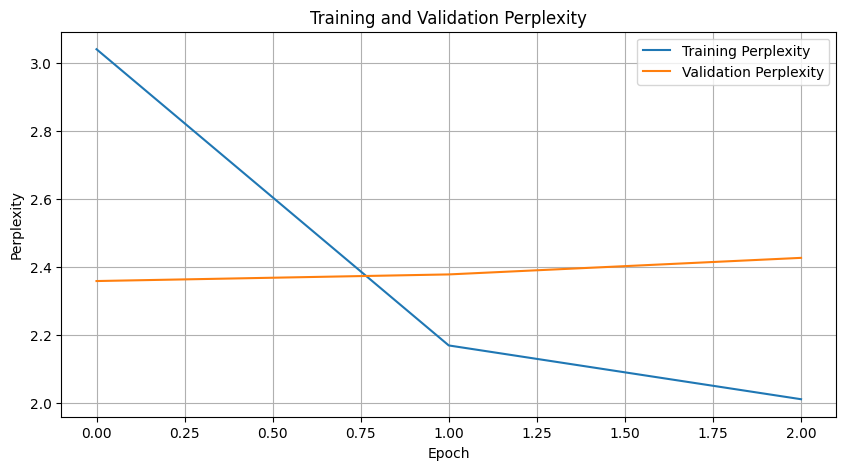

In [65]:
# Настройки обучения
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,  # Увеличиваем батч для GPU
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,  # Используем mixed precision для ускорения обучения
    learning_rate=5e-5,
    lr_scheduler_type="linear",  # Линейное уменьшение скорости обучения
)

# Обучаем модель
model, tokenizer = train_model(train_dataset, test_dataset, tokenizer, training_args)